In [1]:
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import PollingSystem as PS
import MarkovianRP as MRP
import dtr

In [74]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(23)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 6#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

23.000000 dBm	-7.000000 dBW	199.526231 mW	0.199526 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-80.90174759231485
SNR Threshold: 27


In [75]:
#Setup the system:

#For now, use same channel params, basd on the San Francisco measurements
nPL = 4.2  
kPL = -35

decorrSH = 3.09    
alpha = 8.41
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1



#6 remote stations
l = 20
qBase = np.array([[23,24], [23-(np.sqrt(2)*l/2), 24-(np.sqrt(2)*l/2)], [27,24], [27+(np.sqrt(2)*l/2), 24-(np.sqrt(2)*l/2)],
                  [25, 24+2*np.sqrt(2)], [25,24+2*np.sqrt(2) + l]])
cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10


Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


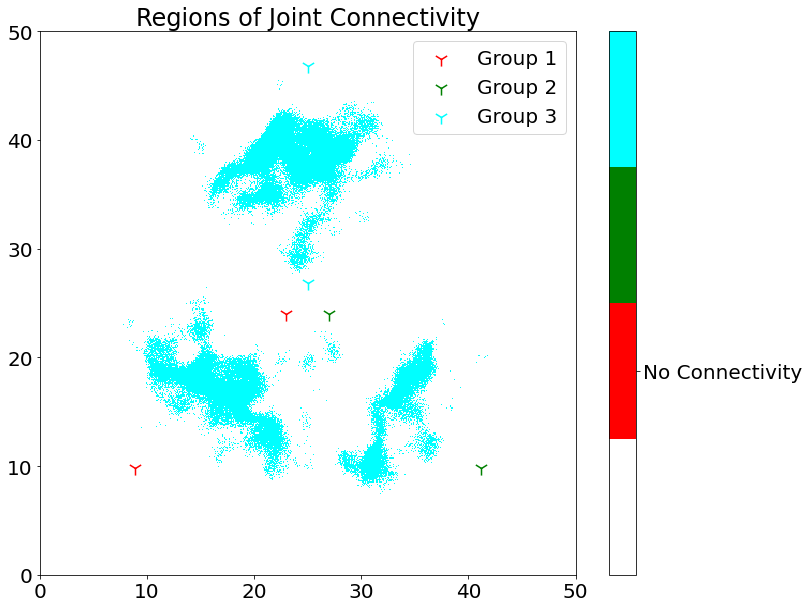

In [76]:
#Create Comm Channels
ccs = [CC.CommChannel(cps[i], region, res) for i in range(len(cps))]
for cc in ccs:
        cc.generateSH();cc.generateMP(2)

#now display the regions so we know if this is going to work for us
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
cfs = [cc.getConnectionField(GAMMA_TH) for cc in ccs]
r1 = 1*cfs[0]*cfs[1]; r2 = 1*cfs[2]*cfs[3]; r3 = 1*cfs[4]*cfs[5];
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)
plt.legend()    
plt.show()

In [77]:
#Create the predicted channel
pct_sample = 0.005
n_samples = int(pct_sample*(x_max - x_min)*(y_max - y_min)*res**2)
print('Drawing %d samples from each region'%(n_samples))
pcs = []
for cc in ccs:
    xs, vals = cc.sampleChannel(n_samples)
    pcs.append(CC.PredictedChannel(cc.cp, cc.region, res, xs, vals))
    print('Completed PredictedChannel %d'%(len(pcs)))

%store pcs

Drawing 1250 samples from each region
Completed PredictedChannel 1
Completed PredictedChannel 2
Completed PredictedChannel 3
Completed PredictedChannel 4
Completed PredictedChannel 5
Completed PredictedChannel 6
Stored 'pcs' (list)


In [78]:


#%store -r pcs

In [79]:
#now display the regions so we know if this is going to work for us
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
pfs = [pc.getPConField(GAMMA_TH) for pc in pcs]

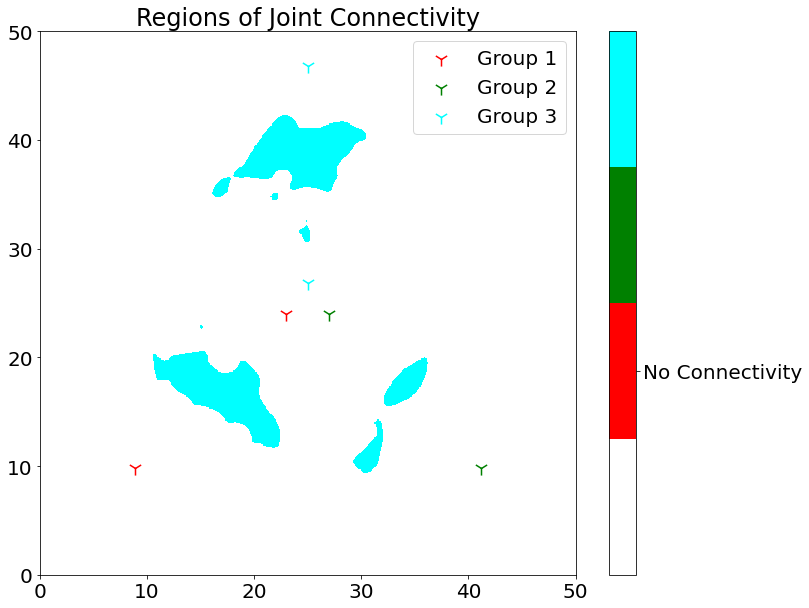

In [80]:
p_th = 0.7
for pc in pcs:
    pc.setPth(p_th)

r1 = 1*(pfs[0]*pfs[1]>p_th); r2 = 1*(pfs[2]*pfs[3]>p_th); r3 = 1*(pfs[4]*pfs[5]>p_th);
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)
plt.legend()    
plt.show()

In [81]:
from importlib import reload 
reload(dtr)
# reload(MRP)
reload(PS)
reload(PC)

<module 'pointcloud' from '/home/win/dev/CommMotionPlanning/python/touring_relay/../geometry/pointcloud.py'>

In [82]:
bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)

p3 = [0.2, 0.1, 0.02]
pis = []
Xs = []
Ws =[]

#Naive Variables
npis = []
nXs = []
nWs =[]

#
all_els = []


els = np.ones(len(pcs)//2)/(beta*len(pcs))
sys = dtr.DTR(pcs, els, beta, th=GAMMA_TH)
for i in range(len(p3)):
    #make it easy to ensure stability by givein arrivals in terms of beta
    els = np.array([0.2/beta, 0.2/beta, p3[i]/beta])
    all_els.append(els)
    sys.ps.Ls = els
    W, pi, X = sys.optimize(x_opt_method=3, do_plot = False)
    pis.append(pi)
    Xs.append(X)
    Ws.append(W)
    nW, npi, nX = sys.naive_policy()
    npis.append(npi)
    nXs.append(nX)
    nWs.append(nW)
    print("============================================================")
    print("============================================================")
    print('Optimized:')
    print('\tPi: '+str(pi)+'\n\tRelay Positions: '+ str(X)+'\n\tWaiting Time: '+str(W))
    print('Naive:')
    print('\tPi: '+str(npi)+'\n\tRelay Positions: '+ str(nX)+'\n\tWaiting Time: '+str(nW))
    print("============================================================")
    print("============================================================")

Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
18 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
9 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 4 possibly non-convex polygons
20 total subregions
Optimized Policy Waiting Time: 96.2988
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 1 logical processors, using up to 1 threads
Optimize a model with 250 rows, 56 columns and 751 nonzeros
Model fingerprint: 0xe567a275
Model has 3 quadratic constraints
Variable types: 9 continuous, 47 integer (47 binary)
Coefficient statistics:
  Matrix range     [9e-02, 1e+04]
  QMatrix range    [1e+00, 2e+00]
  Objective range  [9e-02, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]

     0     0    0.00000    0   17          -    0.00000      -     -    0s
     0     0    0.00000    0   16          -    0.00000      -     -    0s
     0     0    0.00000    0   16          -    0.00000      -     -    0s
     0     0    0.00000    0   14          -    0.00000      -     -    0s
     0     0    0.00000    0   16          -    0.00000      -     -    0s
     0     0    0.00000    0   16          -    0.00000      -     -    0s
     0     0    0.00000    0   16          -    0.00000      -     -    0s
     0     0    0.00000    0   16          -    0.00000      -     -    0s
H    0     0                       6.2710857    0.00000   100%     -    0s
     0     2    0.00000    0   16    6.27109    0.00000   100%     -    0s
H    8     8                       6.1355107    0.00000   100%  10.4    0s
H   54    48                       6.0650948    0.00000   100%  12.3    0s
*  106    50              65       6.0650948    0.00000   100%   6.8    0s
*  187    67             

*  708   181              46       3.7544996    0.00000   100%   6.0    0s
H 1530   299                       3.7541770    1.28430  65.8%   5.9    1s
* 1747   283              54       3.7541670    1.34254  64.2%   5.7    1s
* 1748   268              54       3.7541670    1.34254  64.2%   5.7    1s

Cutting planes:
  Implied bound: 3
  PSD: 11

Explored 4589 nodes (22017 simplex iterations) in 2.41 seconds
Thread count was 1 (of 1 available processors)

Solution count 10: 3.75417 3.75417 3.75418 ... 4.82464

Optimal solution found (tolerance 1.00e-04)
Best objective 3.754167025876e+00, best bound 3.753794675233e+00, gap 0.0099%
Transition probabilities:  [0.50116373 0.34342439 0.15541188]
Points:  [[22.3        13.3       ]
 [29.2        10.5       ]
 [24.84116862 30.7       ]]
Optimized Location Waiting Time: 40.4538
Optimized Location Waiting Time: 40.4538
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc

Presolved model has 15 bilinear constraint(s)
Variable types: 24 continuous, 47 integer (47 binary)

Root relaxation: objective 0.000000e+00, 21 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   11          -    0.00000      -     -    0s
     0     0    0.00000    0   17          -    0.00000      -     -    0s
     0     0    0.00000    0   17          -    0.00000      -     -    0s
     0     0    0.00000    0   16          -    0.00000      -     -    0s
     0     0    0.00000    0   16          -    0.00000      -     -    0s
     0     0    0.00000    0   14          -    0.00000      -     -    0s
     0     0    0.00000    0   16          -    0.00000      -     -    0s
     0     0    0.00000    0   16          -    0.00000      -     -    0s
     0     0    0.00000    0   16          -    0.00000      -     -    0s
   

* 2358   268              51       2.4929574    1.81509  27.2%   5.7    1s
* 2430   248              53       2.4929572    1.86328  25.3%   5.6    1s

Cutting planes:
  Implied bound: 2
  PSD: 3

Explored 4155 nodes (17731 simplex iterations) in 2.14 seconds
Thread count was 1 (of 1 available processors)

Solution count 10: 2.49296 2.49296 2.49297 ... 2.77618

Optimal solution found (tolerance 1.00e-04)
Best objective 2.492957151125e+00, best bound 2.492721022865e+00, gap 0.0095%
Transition probabilities:  [0.55308845 0.39643635 0.0504752 ]
Points:  [[22.3        12.2       ]
 [29.2        10.5       ]
 [25.02015298 30.7       ]]
Optimized Location Waiting Time: 23.0056
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 1 logical processors, using up to 1 threads
Optimize a model with 250 rows, 56 columns and 751 nonzeros
Model fingerprint: 0x77166e20
Model has 3 qu

In [83]:
for i in range(len(p3)):
    print("============================================================")
    print("============================================================")
    print('Arrival Rates: ' + str(all_els[i]))
    print('Routing Policy')
    print('\tOptimal: '+str(pis[i])+'\tNaive: ' + str(npis[i]))
    print('Waiting Time')
    print('\tOptimal: %.2f\tNaive: %.2f\tDifference: %.2f'%(Ws[i], nWs[i], nWs[i] - Ws[i]) )

print("============================================================")
print("============================================================")

Arrival Rates: [2.4 2.4 2.4]
Routing Policy
	Optimal: [0.37278443 0.31772518 0.30949039]	Naive: [0.33333333 0.33333333 0.33333333]
Waiting Time
	Optimal: 52.23	Naive: 52.41	Difference: 0.18
Arrival Rates: [2.4 2.4 1.2]
Routing Policy
	Optimal: [0.51266802 0.36253601 0.12479597]	Naive: [0.4 0.4 0.2]
Waiting Time
	Optimal: 40.06	Naive: 41.13	Difference: 1.07
Arrival Rates: [2.4  2.4  0.24]
Routing Policy
	Optimal: [0.5542516  0.39531493 0.05043347]	Naive: [0.47619048 0.47619048 0.04761905]
Waiting Time
	Optimal: 23.01	Naive: 30.85	Difference: 7.84


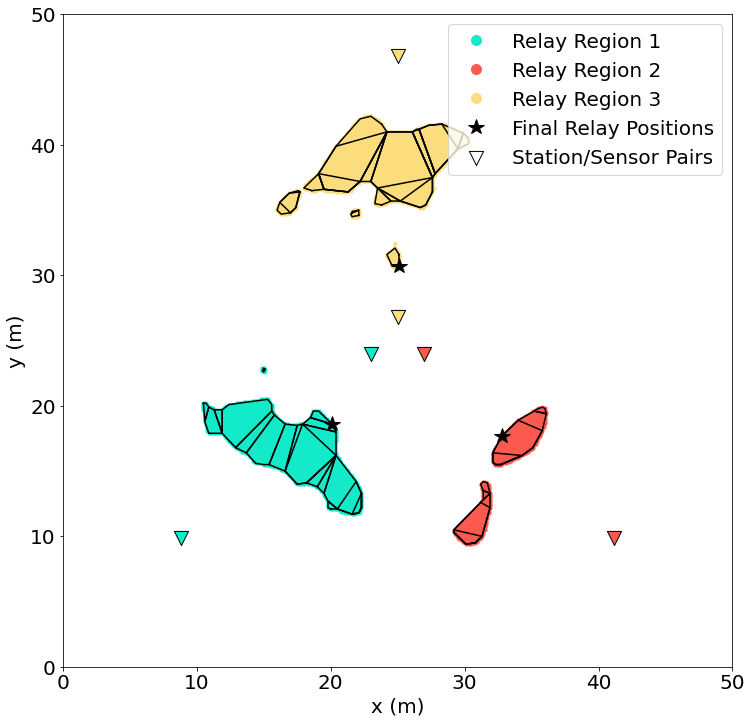

In [84]:
fs=20
plt.rcParams['font.size'] = fs
fig = plt.figure(figsize=(12,12))

#plot the connectivity fields
colors = ['xkcd:aqua', 'xkcd:coral', 'xkcd:wheat', 'c']
for i in range(sys.n):
    Xi = sys.Xis[i]
    pts = Xi['points']
    plt.plot(pts[:,0],  pts[:,1], '.', color=colors[i])
    #dummy series for better legend formatting
    plt.plot([-100], [-100], '.', color=colors[i], markersize=20, label='Relay Region %d'%(i+1))
    reg = sys.cregions[i]
    reg.plot_polys()


#plot base stations
for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                color=colors[i], marker='v', s=200, edgecolor='k')
#dummy series for legend formatting
plt.scatter([-100], [-100], marker='v', s=200, color='w', edgecolor='k', label='Station/Sensor Pairs')
pod_colors = []
x=Xs[0]
plt.plot(x[:,0], x[:,1], '*k', markersize=16, label='Final Relay Positions')
plt.xlim(region[1], region[0])
plt.ylim(region[3], region[2])
plt.xlabel('x (m)', fontsize=fs)
plt.ylabel('y (m)', fontsize=fs)

plt.legend(prop={'size':fs}, loc='upper right')
plt.savefig('sim_eqtri_pairs_%d_pth_%.2f_gammath_%d_alt.png'%(sys.n, sys.p_th, sys.gamma_th),format='png')
plt.show()

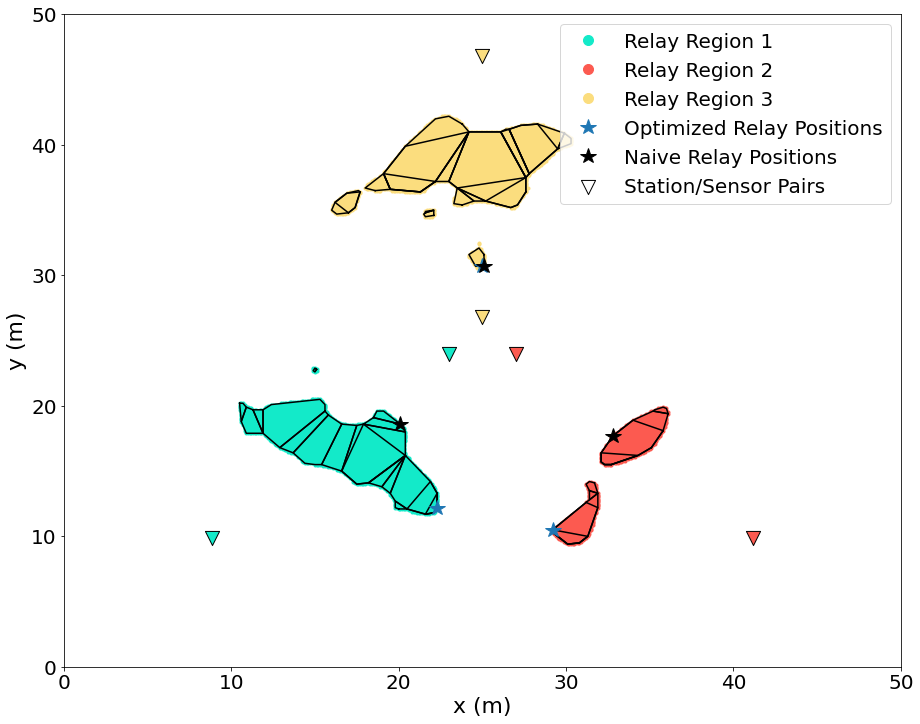

In [85]:
fs=20
plt.rcParams['font.size'] = fs
fig = plt.figure(figsize=(15,12))

#plot the connectivity fields
colors = ['xkcd:aqua', 'xkcd:coral', 'xkcd:wheat', 'c']
for i in range(sys.n):
    Xi = sys.Xis[i]
    pts = Xi['points']
    plt.plot(pts[:,0],  pts[:,1], '.', color=colors[i])
    #dummy series for better legend formatting
    plt.plot([-100], [-100], '.', color=colors[i], markersize=20, label='Relay Region %d'%(i+1))
    reg = sys.cregions[i]
    reg.plot_polys()


#plot base stations
for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                color=colors[i], marker='v', s=200, edgecolor='k')
#dummy series for legend formatting
plt.scatter([-100], [-100], marker='v', s=200, color='w', edgecolor='k', label='Station/Sensor Pairs')


x=Xs[2]
plt.plot(x[:,0], x[:,1], '*', markersize=16, label='Optimized Relay Positions')
x= nXs[2]
plt.plot(x[:,0], x[:,1], '*', markersize=16, color='k', label='Naive Relay Positions')
#for the legend
#plt.plot([-100], [100], '*', color='w', markeredgecolor='k', markersize=16, label='Final Relay Positions')
#ax = plt.gca()
#ax.annotate('')

plt.xlim(region[1], region[0])
plt.ylim(region[3], region[2])
plt.xlabel('x (m)', fontsize=22)
plt.ylabel('y (m)', fontsize=22)

plt.legend(prop={'size':fs}, loc='upper right')
plt.savefig('sim_eqtri_pairs_%d_pth_%.2f_gammath_%d_alt.png'%(sys.n, sys.p_th, sys.gamma_th),format='png')
plt.show()

In [86]:
#Now actually simulate the system
def MotionPower(k1, k2, v=1):
    return k1*v + k2

MOTION_POWER = MotionPower(7.5, 0.29)
ps = sys.ps
hrs = 1
minutes = hrs*60
seconds = minutes*60
#look at policy-invariant values
print("Average Data In/Out: " + str(ps.LSys()))
print("MB serviced in 1 hr: " + str(ps.LSys()*60*60))
AP = ps.RhoSys()*MOBILE_TX_POWER.W + (1-ps.RhoSys())*MOTION_POWER
print("Average Power (W): "+str(AP))
print("Energy Consumption Over 1 Hr (J)" + str(AP*60*60))

Average Data In/Out: 5.040000000000001
MB serviced in 1 hr: 18144.000000000004
Average Power (W): 4.602001017228692
Energy Consumption Over 1 Hr (J)16567.20366202329


In [96]:
#simulate the optimized system
rp = MRP.RandomRP(pis[2])
S =  dtr.XtoS(Xs[2])
wait = ps.calc_avg_wait(rp, S)
print("Theoretical Wait Time: %.4f"%(wait))
#now run a bunch of simulations and look at the averages
FAWT = 0
TMB = 0
TE = 0
n_trials = 100
for i in range(n_trials):
    xt, wt, queues, total_travel_time = ps.simulate(rp, S, seconds)
    FAWT += wt[-1][1]
    MB_serviced = 0
    for q in queues:
        MB_serviced += len(q.wait_times)
    TMB += MB_serviced
    TE += MOTION_POWER*total_travel_time + MOBILE_TX_POWER.W*beta*MB_serviced
print("Average Empirical Wait Time (s): " + str(FAWT/n_trials))
print("MB serviced: " + str(TMB/n_trials))
print("Energy Consumption (J): " + str(TE/n_trials))


Theoretical Wait Time: 23.0056
Average Empirical Wait Time (s): 24.74568359531059
MB serviced: 18024.81
Energy Consumption (J): 16663.84694225621


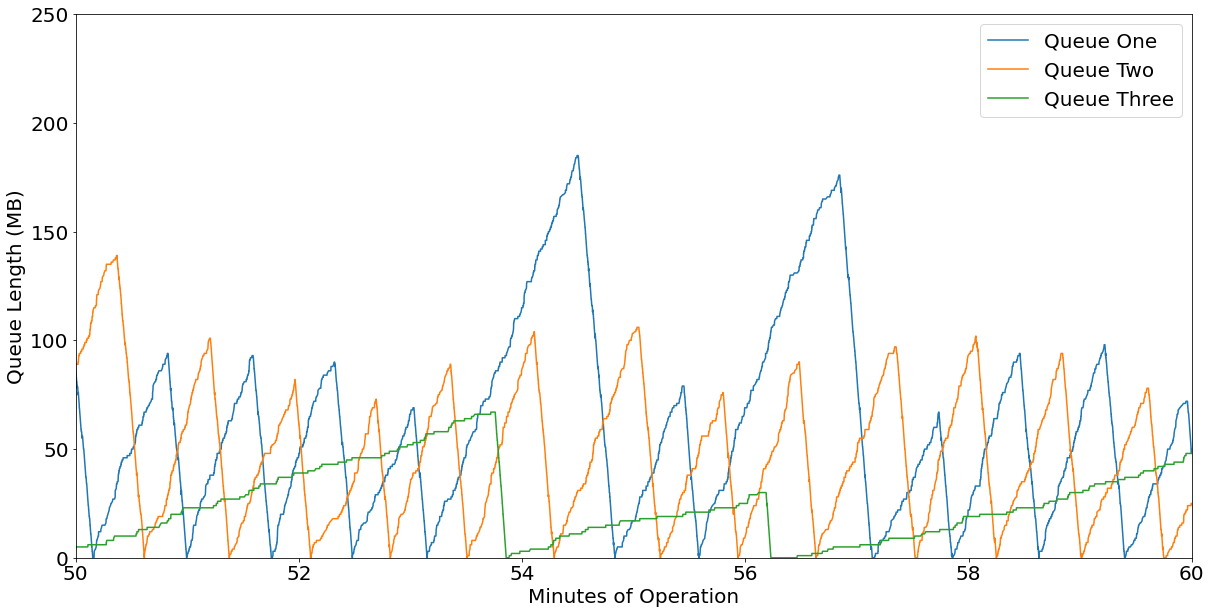

In [101]:
xt = np.array(xt)
fig = plt.figure(figsize=[20,10])
#plt.plot(xt[:,0], xt[:,1], label = 'Queue Servicing')
plt.plot(xt[:,0]/60, xt[:,2], label = 'Queue One')
plt.plot(xt[:,0]/60, xt[:,3], label = 'Queue Two')
plt.plot(xt[:,0]/60, xt[:,4], label = 'Queue Three')

plt.xlim(minutes-10,minutes)
plt.ylim(0,250)
plt.legend()
plt.xlabel('Minutes of Operation')
plt.ylabel('Queue Length (MB)')
plt.show()

In [102]:
#simulate the naive system
rp = MRP.RandomRP(npis[2])
S =  dtr.XtoS(nXs[2])
wait = ps.calc_avg_wait(rp, S)
print("Theoretical Wait Time: %.4f"%(wait))
#now run a bunch of simulations and look at the averages
FAWT = 0
TMB = 0
TE = 0
for i in range(n_trials):
    xt, wt, queues, total_travel_time = ps.simulate(rp, S, seconds)
    FAWT += wt[-1][1]
    MB_serviced = 0
    for q in queues:
        MB_serviced += len(q.wait_times)
    TMB += MB_serviced
    TE += MOTION_POWER*total_travel_time + MOBILE_TX_POWER.W*beta*MB_serviced
print("Average Empirical Wait Time (s): " + str(FAWT/n_trials))
print("MB serviced: " + str(TMB/n_trials))
print("Energy Consumption (J): " + str(TE/n_trials))

Theoretical Wait Time: 30.8477
Average Empirical Wait Time (s): 30.258946587813142
MB serviced: 17980.85
Energy Consumption (J): 16698.267153353856


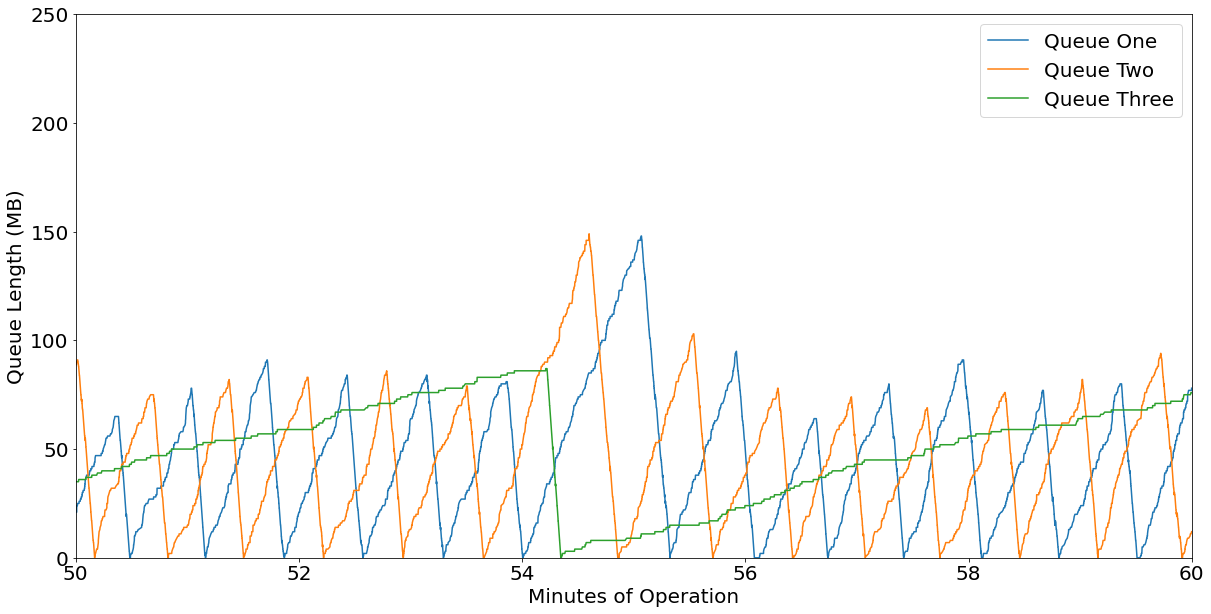

In [103]:
xt = np.array(xt)
fig = plt.figure(figsize=[20,10])
#plt.plot(xt[:,0], xt[:,1], label = 'Queue Servicing')
plt.plot(xt[:,0]/60, xt[:,2], label = 'Queue One')
plt.plot(xt[:,0]/60, xt[:,3], label = 'Queue Two')
plt.plot(xt[:,0]/60, xt[:,4], label = 'Queue Three')

plt.xlim(minutes-10,minutes)
plt.ylim(0,250)
plt.legend()
plt.xlabel('Minutes of Operation')
plt.ylabel('Queue Length (MB)')
plt.show()

In [104]:
els

array([2.4 , 2.4 , 0.24])

In [107]:
pis[-1]

array([0.5542516 , 0.39531493, 0.05043347])